In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import time
from custom_tqdm import TqdmNotebookCallback
from tqdm.keras import TqdmCallback
import albumentations as A
import random

import matplotlib.pyplot as plt
from functools import partial
import numpy as np


In [2]:
import os
import imageio as io
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
import cv2
from pathlib import Path



In [3]:
%matplotlib inline

In [62]:
augs = [
    A.RandomGamma((40,40),p=1),
    A.RandomBrightness(limit=0.5,p=1),
    A.RandomContrast(limit=1,p=1),
    A.RGBShift(40,40,40,p=1),
    A.Downscale(scale_min=0.2,scale_max=0.2,p=1),
    A.ChannelShuffle(p=1),
    A.InvertImg(p=1),
    A.VerticalFlip(p=1),
    A.RandomRotate90(p=1),
]
reshape = A.Resize(200,200)
names = [
    'RandomGamma',
    'RandomBrightness',
    'RandomContrast',
    'RGBShift',
    'Downscale',
    'ChannelShuffle',
    'InvertImg',
    'Flip',
    'RandomRotate90°'
]

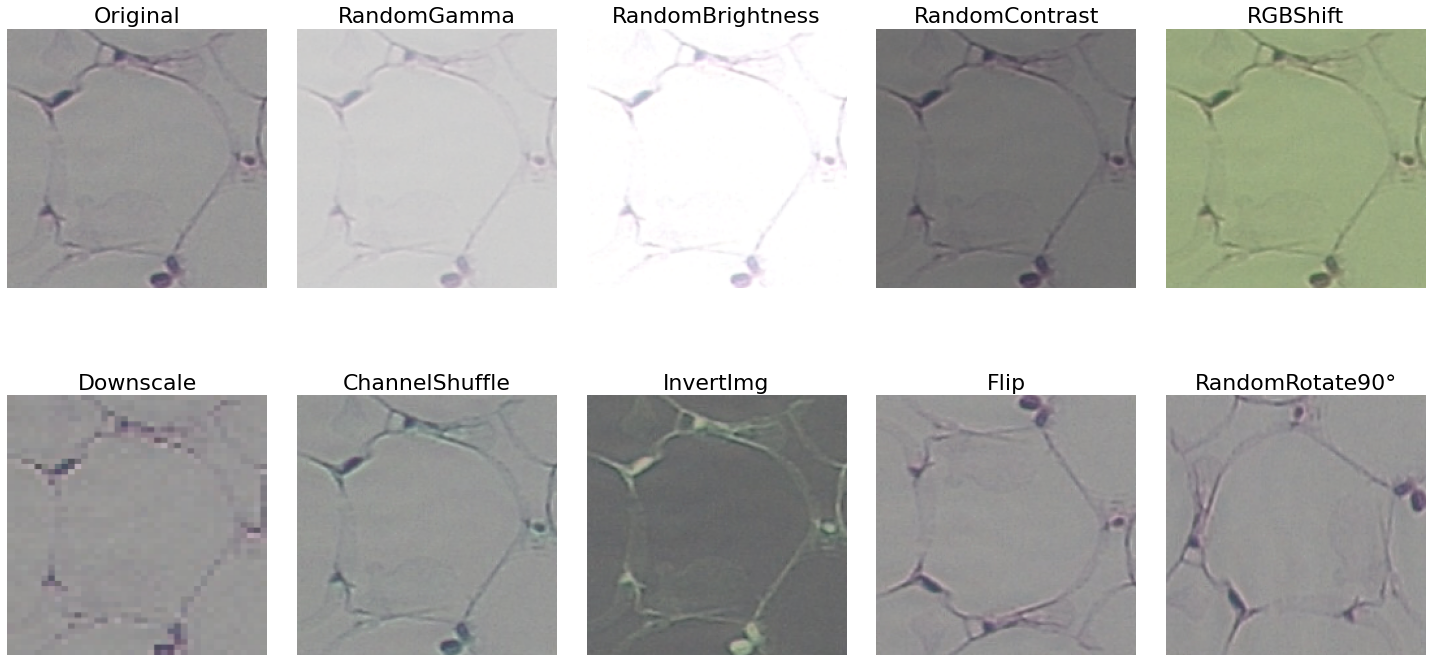

In [69]:
data_dir = Path('data')
data_groups = next(os.walk(data_dir))[1]
img = []
data = []
img_name_dict = {}
img_idx = 0
for dg in data_groups[1:]:
    img_dir = data_dir/dg/'done'
    img_names = os.listdir(img_dir)
    for name in img_names:
        img_path = str(img_dir/name)
        img.append(io.imread(img_path))
        img_name_dict[img_path] = img_idx
        img_idx += 1

    json_dir = data_dir/dg/'save'
    json_names = os.listdir(json_dir)
    dg_data = []
    for name in json_names[-1:]:
        with open(str(json_dir/name),'r') as j:
            dg_data.extend(json.load(j))
    for dg_datum in dg_data :
        long_img_name = str(img_dir/dg_datum['image'])
        dg_datum['image'] = img_name_dict[long_img_name]
    data.extend(dg_data)
d= data[3]
image = img[d['image']].copy()

d['mask_min'] = np.min(d['mask'], axis=1)
d['mask_max'] = np.max(d['mask'], axis=1) + 1
x_min, y_min = d['mask_min']
x_max, y_max = d['mask_max']

crop_min = (max(0, x_min-random.randrange(5,30)),
            max(0, y_min-random.randrange(5,30)))
crop_max = (min(d['size'][0],x_max+random.randrange(5,30)),
            min(d['size'][1],y_max+random.randrange(5,30)))
row_ratio = image.shape[0] / d['size'][1]
col_ratio = image.shape[1] / d['size'][0]
cx_min = int(col_ratio*crop_min[0])
cy_min = int(row_ratio*crop_min[1])

cx_max = int(col_ratio*crop_max[0])
cy_max = int(row_ratio*crop_max[1])

cropped_image = np.swapaxes(image[cy_min:cy_max,cx_min:cx_max],0,1)

fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(2,np.ceil((len(augs)+1)/2),1)
ax.imshow(reshape(image=cropped_image)['image'])
ax.set_title('Original', fontsize=22)
plt.axis('off')
for i, aug in enumerate(augs):
    ax = fig.add_subplot(2,np.ceil((len(augs)+1)/2),i+2)
    img = reshape(image=(aug(image=cropped_image)['image']))['image']
    ax.imshow(img)
    ax.set_title(names[i], fontsize=22)
    plt.axis('off')
fig.tight_layout(h_pad=2, w_pad=3)
plt.show()